# Bike Sharing Demands

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

In [172]:
import numpy as np 
import pandas as pd 
import seaborn as sns #시각화를 위한 라이브러리
import matplotlib.pyplot as plt
%matplotlib inline 
import calendar 
from datetime import datetime

In [173]:
pip install workalendar

Note: you may need to restart the kernel to use updated packages.


## 1. 데이터 불러오기

In [246]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 2. EDA 및 전처리

### 2-1. 데이터 개요

 - datetime - hourly date + timestamp  
 - season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
 - holiday - whether the day is considered a holiday
 - workingday - whether the day is neither a weekend nor holiday
 - weather 
      + 1: Clear, Few clouds, Partly cloudy, Partly cloudy
      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
 - temp - temperature in Celsius
 - atemp - "feels like" temperature in Celsius
 - humidity - relative humidity
 - windspeed - wind speed
 - casual - number of non-registered user rentals initiated
 - registered - number of registered user rentals initiated
 - count - number of total rentals

In [247]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [248]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [249]:
test.shape[0]

6493

### 2-2. 결측치 확인

In [250]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [251]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


두 table 모두 결측치는 없다.

### 2-3. 추가 변수 설정

년, 월, 일, 시간 변수 생성

In [252]:
train["datetime"] = pd.to_datetime(train["datetime"])
train["year"] = train['datetime'].dt.year
train["month"] = train['datetime'].dt.month
train["day"] = train['datetime'].dt.day
train["hour"] = train['datetime'].dt.hour

test["datetime"] = pd.to_datetime(test["datetime"])
test["year"] = test['datetime'].dt.year
test["month"] = test['datetime'].dt.month
test["day"] = test['datetime'].dt.day
test["hour"] = test['datetime'].dt.hour

요일 변수 생성

In [253]:
from workalendar.usa import UnitedStates
from datetime import datetime

cal=UnitedStates()
train['weekday'] = train['datetime'].dt.weekday
test['weekday'] = test['datetime'].dt.weekday

불쾌지수 변수 생성

In [254]:
# 불쾌지수 구하기: 9/5T - 0.55(1-H)(9/5T-26)+32
train['THI'] = 9/5*train['temp']-0.55*(1-train['humidity']/100)*(9/5*train['temp']-26)+32
test['THI'] = 9/5*test['temp']-0.55*(1-test['humidity']/100)*(9/5*test['temp']-26)+32

변경된 train 데이터 확인

In [255]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday,THI
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5,50.578096
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5,49.310040
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5,49.310040
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5,50.851600
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5,50.851600


### 2-4. Feature Engineering (변수 별 시각화 및 전처리) 

### 1) season

season 변수 재정의

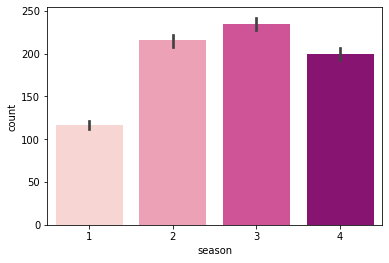

In [256]:
ax = plt.subplots() 
ax = sns.barplot(x='season', y='count', data=train, palette = "RdPu")

In [257]:
def season(month):
    if month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3
    elif month in [12,1,2]:
        return 4

train["season"] = train["month"].apply(season)
test["season"] = test["month"].apply(season)

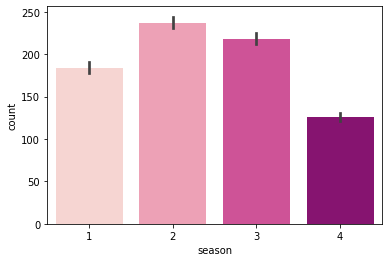

In [258]:
ax = plt.subplots() 
ax = sns.barplot(x='season', y='count', data=train, palette = "RdPu")

여름에 대여량이 가장 많고, 겨울에 대여량이 가장 적다.

### 2) holiday

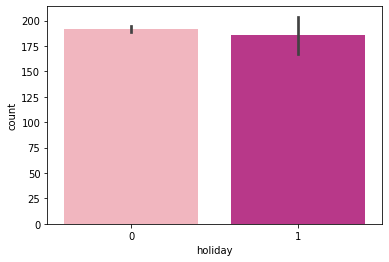

In [186]:
ax = plt.subplots() 
ax = sns.barplot(x='holiday', y='count', data=train, palette = "RdPu")

휴일과 비휴일의 대여량은 비슷하다.

### 3) workingday

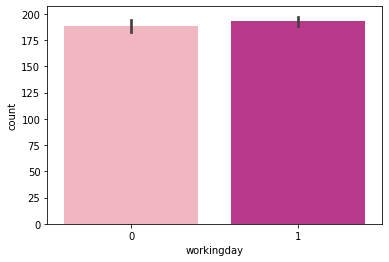

In [187]:
ax = plt.subplots() 
ax = sns.barplot(x='workingday', y='count', data=train, palette = "RdPu")

휴일+주말과 비휴일의 대여량은 비슷하다.

### 4) weather

In [188]:
train.groupby('weather').size()

weather
1    7192
2    2834
3     859
4       1
dtype: int64

weather가 4인 경우 관측이 하나밖에 없으므로 3으로 바꿔준다.

In [189]:
train.loc[train['weather']==4, 'weather']=3

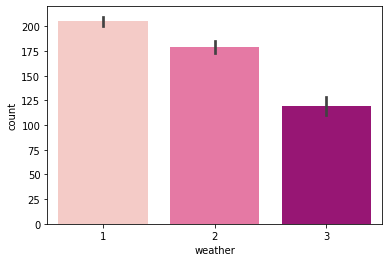

In [190]:
sns.barplot(data = train, x = "weather", y = "count",palette = "RdPu")

날씨가 맑을수록 대여량이 많다.

### 5) temp & atemp

In [191]:
train['temp'].describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

워싱턴 D.C의 날씨는 서울과 비슷한 수준이다.

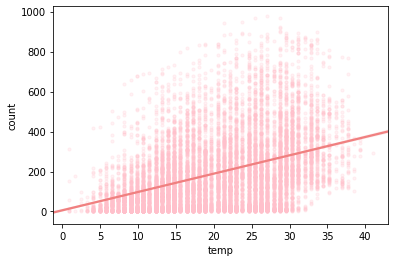

In [192]:
sns.regplot(x='temp', y='count',color = "lightcoral", data=train, scatter_kws={'s':10, 'color' : 'pink', 'alpha' : 0.2})

기온 20℃ - 30℃ 에서 count가 가장 많다.

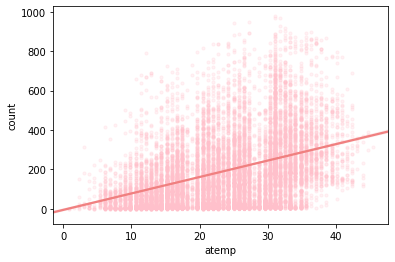

In [193]:
sns.regplot(x='atemp', y='count',color = "lightcoral", data=train, scatter_kws={'s':10, 'color' : 'pink', 'alpha' : 0.2})

체감온도 20℃ - 35℃ 에서 count가 가장 많다.

### 6) humidity

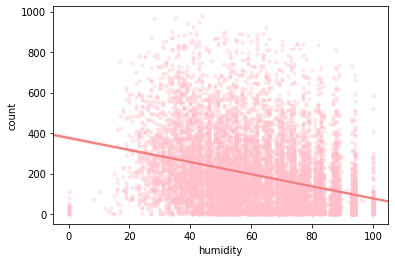

In [194]:
sns.regplot(x='humidity', y='count',color = "lightcoral", data=train, scatter_kws={'s':10, 'color' : 'pink', 'alpha' : 0.3})

습도가 40-60%에서 count가 많다. 

### 7) THI

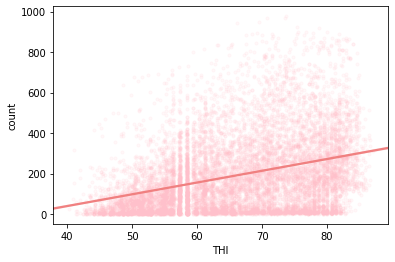

In [195]:
sns.regplot(x='THI', y='count',color = "lightcoral", data=train, scatter_kws={'s':10, 'color' : 'pink', 'alpha' : 0.1})

### 8) windspeed

In [196]:
#train.groupby('windspeed').size()

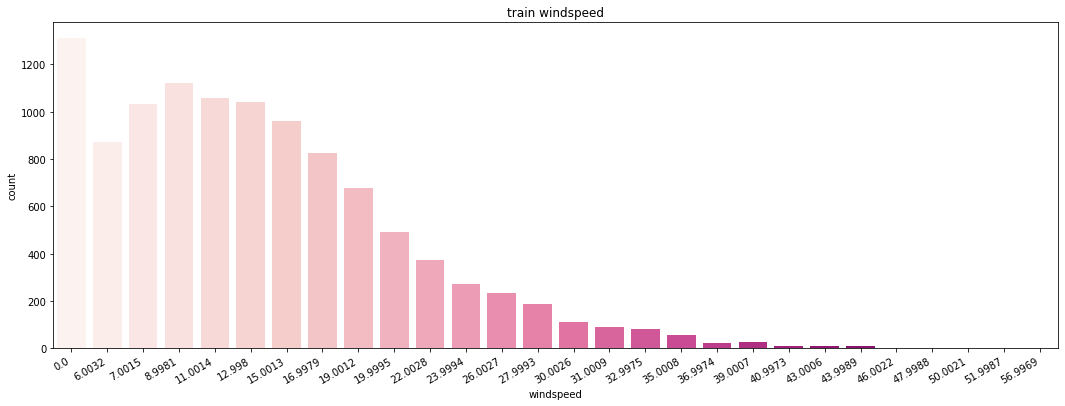

In [197]:
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1, palette = "RdPu")

풍속이 0인 값이 유독 많다. 

0인 값의 위치를 확인해보면 주변 시간에 비해 급격히 0으로 바뀌는 경우가 많기 때문에 잘못된 측정이라고 볼 수 있다. 

따라서 0인 값을 랜덤포레스트 기법을 활용해 다른 값으로 대체해준다.

In [198]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    dataWind0 = data.loc[train['windspeed']==0]
    dataWindNot0 = data.loc[train['windspeed']!=0]
    
    wCol = ['season','weather','humidity','month','temp','year','atemp']
    
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype('str')
    
    rfModel_wind = RandomForestClassifier()
    
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

C:\Users\Hyunjung\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Hyunjung\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Hyunjung\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


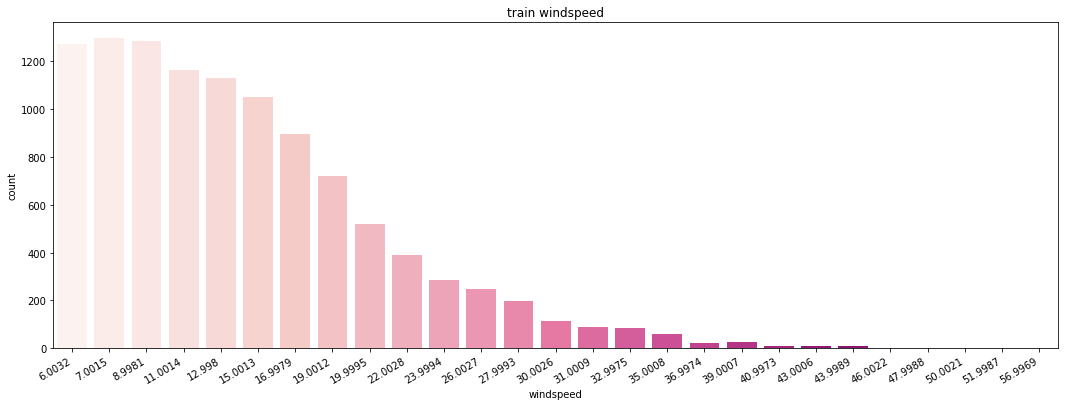

In [199]:
# 0값을 조정한다.
train = predict_windspeed(train)
# test = predict_windspeed(test)

fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1, palette = "RdPu")

### 9) year & month

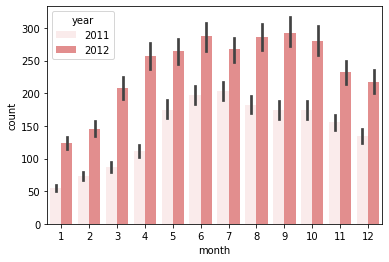

In [200]:
sns.barplot(data = train, x = "month", y = "count", hue = "year", color = 'lightcoral')

날씨가 좋은 6,7,8,9,10월에 사용량이 가장 많다.

### 10) weekday

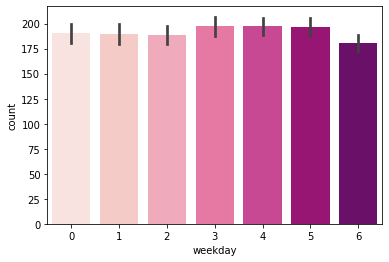

In [201]:
ax = plt.subplots() 
ax = sns.barplot(x='weekday', y='count',data=train, palette = "RdPu")

평일과 주말의 사용량이 크게 다르진 않다. 

목, 금, 토요일의 사용량이 다른 날보다 약간 더 많다.

### 11) hour

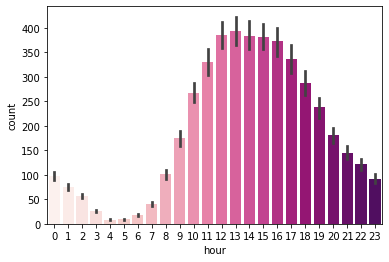

In [205]:
# 주말
ax = plt.subplots()
ax = sns.barplot(x='hour', y='count', data=train.loc[train['weekday']>=5,], palette = "RdPu")

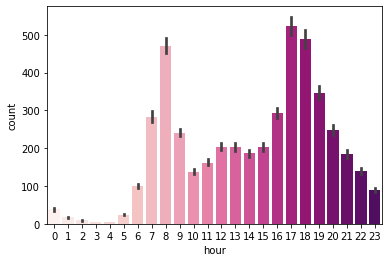

In [206]:
# 평일
ax = plt.subplots()
ax = sns.barplot(x='hour', y='count', data=train.loc[train['weekday']<=4,], palette = "RdPu")

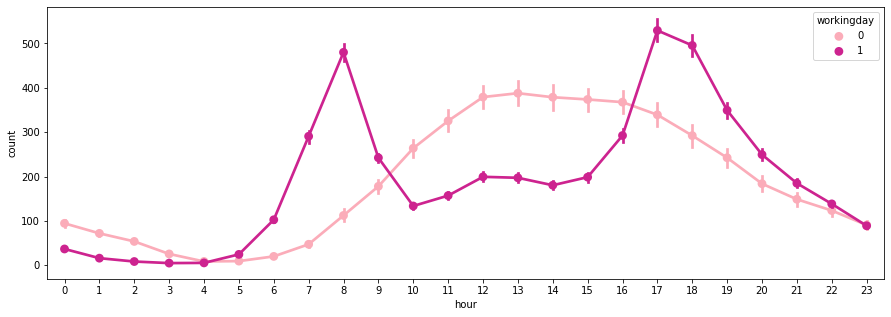

In [204]:
plt.figure(figsize = (15,5))
sns.pointplot(data = train, x = "hour", y = "count", hue = "workingday", palette = "RdPu")

근무일 여부에 따라 시간 별 대여량이 차이난다.

근무일의 경우 출근시간과 퇴근시간에 사용량이 급격히 많아진다.

근무일이 아닌 경우는 이와 상관없이 날씨가 가장 좋은 12시 - 17시에 사용량이 많다. 

### 2-5. 불필요한 변수 삭제

In [210]:
train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday,THI
0,2011-01-01 05:00:00,4,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,5,50.851600
1,2011-01-01 10:00:00,4,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011,1,1,10,5,59.774192


In [211]:
test.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday,THI
0,2011-01-20 00:00:00,4,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3,52.836504
1,2011-01-20 01:00:00,4,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3,52.836504


In [212]:
train = train.drop(['day','casual','registered'],axis=1)
test = test.drop(['day'],axis=1)

day 변수는 train(1-19일)과 test(20일-말일)에 나눠져 있으므로 유의미한 분석 결과를 얻을 수 없으므로 제거한다.

casual과 registered는 예측에 불필요하므로 제거한다.

### 2-6. 변수들 간의 상관관계

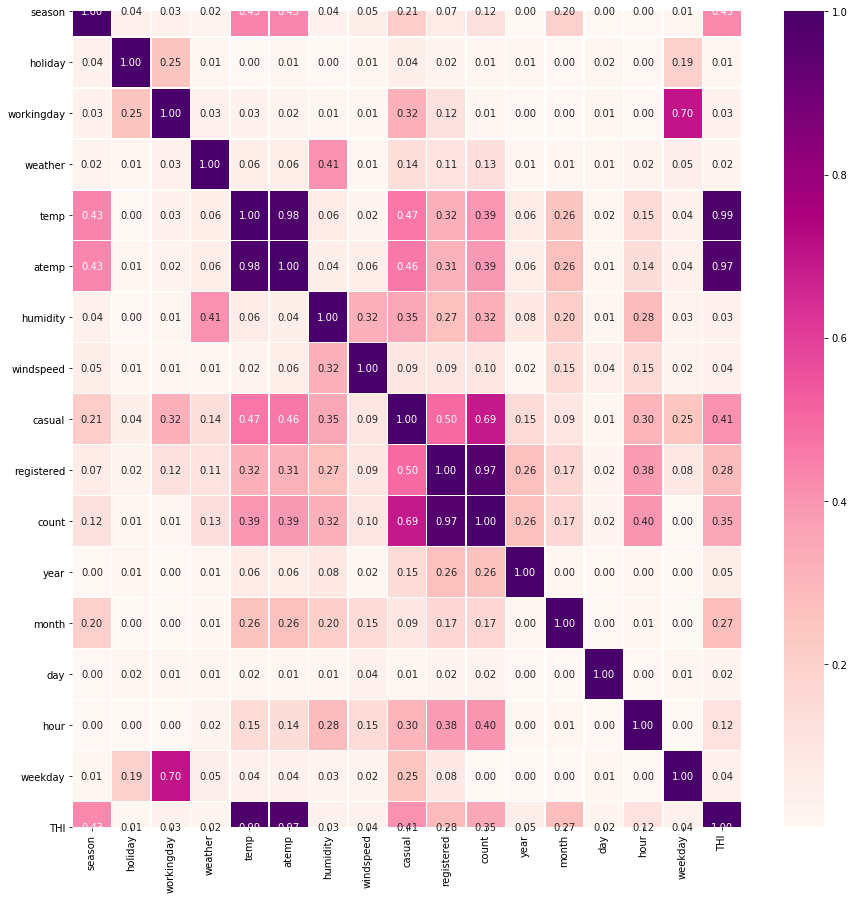

In [261]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr().abs(), annot=True, fmt = '.2f', linewidths=.5, cmap='RdPu')

count 변수와 상관관계가 높은 변수는 hour > temp = atemp > THI > humidity > month > weather > season > windspeed > year > holiday = workingday > weekday 순이다.

상관이 높은 변수들은 시간 변수거나 날씨에 직접적으로 영향을 미치는 연속 변수들이다.

temp와 atemp는 서로 상관관계가 매우 높고 count 변수에 미치는 영향도 비슷하므로 atemp는 제거한다.

In [214]:
train = train.drop(['atemp'],axis=1)
test = test.drop(['atemp'],axis=1)

In [215]:
(train.shape, test.shape)

((10886, 14), (6493, 13))

In [216]:
train.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,hour,weekday,THI
0,2011-01-01 05:00:00,4,0,0,2,9.84,75,6.0032,1,2011,1,5,5,50.851600
1,2011-01-01 10:00:00,4,0,0,1,15.58,76,16.9979,36,2011,1,10,5,59.774192
2,2011-01-01 11:00:00,4,0,0,1,14.76,81,19.0012,56,2011,1,11,5,58.508644
3,2011-01-01 12:00:00,4,0,0,1,17.22,77,19.0012,84,2011,1,12,5,62.364006
4,2011-01-01 13:00:00,4,0,0,2,18.86,72,19.9995,94,2011,1,13,5,64.724008


## 3. Modeling

### 3-1. Decision Tree

In [217]:
col = ['season','holiday','workingday','weather','temp','humidity','windspeed','year','month','hour','weekday','THI']
x_train = train[col]
x_test = test[col]
y_train = train['count']

In [218]:
from sklearn.model_selection import train_test_split
X_train , X_valid ,Y_train , Y_valid = train_test_split(x_train,y_train,test_size = 0.25, random_state = 201)

머신러닝 모델에 train 데이터를 100% 학습시킨 후 test 데이터에 모델을 적용했을 때 Overfitting 될 수 있음. 

train을 train / validation으로 일정 비율 쪼갠 다음에 학습 시에는 train 셋으로 학습 후 중간중간 validation 셋으로 내가 학습한 모델 평가

만약, 모델이 과적합되었다면, validation 셋으로 검증시 예측율이나 오차율이 떨어지는 현상을 확인할 수 있으며, 이런 현상이 나타나면 학습 종료

In [219]:
def RMSLE(predictions , realizations):
    predictions_use = predictions.clip(0)
    rmsle = np.sqrt(np.mean(np.array(np.log(predictions_use+1)-np.log(realizations+1))**2))
    return rmsle

In [220]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_split=25 , random_state=200)
dtr_model = dtr.fit(X_train,Y_train)

In [221]:
dtr_pred = dtr_model.predict(X_valid)

In [222]:
#pd.DataFrame(dtr_model.feature_importances_,index=col)

In [223]:
RMSLE(dtr_pred,Y_valid)

0.37551723009777277

In [224]:
test_dt =  dtr.fit(x_train,y_train)
predict_dt = test_dt.predict(x_test)
dt_clipped = pd.Series(predict_dt.clip(0))

In [225]:
sub_dt_all_vars = pd.DataFrame({'datetime':test.datetime, 'count':predict_dt})
#sub_dt

In [226]:
sub_dt_all_vars.to_csv('sub_dt_all_vars.csv', index=False)

#### => kaggle score(RMSLE): 0.52623

### 3-2. Random Forest #1

 - 변수 전체 사용

In [227]:
train['log_count'] = np.log(train['count']+1)

In [228]:
train_x = train[['season','holiday','workingday','weather','temp','humidity','windspeed','year','month','hour','weekday','THI']]
test_x = test[['season','holiday','workingday','weather','temp','humidity','windspeed','year','month','hour','weekday','THI']]
train_y = train['log_count']

In [229]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

In [230]:
rf = RandomForestRegressor(random_state=0)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

In [231]:
rf_param_grid = {
    'n_estimators':[100,200],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[3,5,7,10],
    'min_samples_split':[2,3,5,10]
}

rf_grid = GridSearchCV(rf, param_grid = rf_param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(train_x, train_y)

C:\Users\Hyunjung\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12],
  

In [236]:
rf_grid.best_params_

{'max_depth': 12,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 200}

In [237]:
model = rf_grid.best_estimator_
predictions = np.exp(model.predict(test_x))-1

In [238]:
sub_rf_all_vars = pd.DataFrame({'datetime':test.datetime, 'count':predictions})
#sub_rf_all_vars

In [93]:
sub_rf_all_vars.to_csv('sub_rf_all_vars.csv', index=False)

#### => kaggle score(RMSLE): 0.45602

### 3-3. Random Forest #2

 - 변수 전체 사용, 위의 best_praamss_를 기반으로 parameter 조정

In [105]:
rf_param_grid = {
    'n_estimators':[200,300],
    'max_depth':[12,14,16,18],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':[2,3]
}

rf_grid = GridSearchCV(rf, param_grid = rf_param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(train_x, train_y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [12, 14, 16, 18],


In [106]:
rf_grid.best_params_

{'max_depth': 18,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [91]:
model = rf_grid.best_estimator_
predictions = np.exp(model.predict(test_x))-1

In [92]:
sub_rf_all_vars_par_tuned = pd.DataFrame({'datetime':test.datetime, 'count':predictions})
#sub_rf_all_vars_par_tuned

,datetime,count
0,2011-01-20 00:00:00,10.807559
1,2011-01-20 01:00:00,4.551790
2,2011-01-20 02:00:00,3.220810
3,2011-01-20 03:00:00,2.669468
4,2011-01-20 04:00:00,2.414015
...,...,...
6488,2012-12-31 19:00:00,363.271438
6489,2012-12-31 20:00:00,238.712999
6490,2012-12-31 21:00:00,173.925404
6491,2012-12-31 22:00:00,117.987197


In [93]:
sub_rf_all_vars_par_tuned.to_csv('sub_rf_all_vars_par_tuned.csv', index=False)

#### => kaggle score(RMSLE): 0.45488

#### parameter (max_depth, min_sample_leaf)를 조정한 값이 예측력이 더 좋다.

### 3-4. Random Forest #3

 - 변경된 parameter 상세값 적용
 - 예측에 사용되는 변수 중 의미가 중복되는 일부를 제거
    - THI는 온도와 습도의 선형관계로 이루어진 변수이므로 temp와 humidity 제거
    - workingday (= holiday + 주말) 는 holiday를 포함하므로 holiday를 제거

Feature를 제거해 차원을 축소하는 이유

 - 더 나은 성능의 모델을 만들기 위해
 - 이해하기 쉬운 모델을 만들기 위해
 - 더 빠르게 실행되는 모델을 만들기 위해

In [52]:
train['log_count'] = np.log(train['count']+1)

In [107]:
train_x = train[['season','workingday','weather','windspeed','year','month','hour','weekday','THI']]
test_x = test[['season','workingday','weather','windspeed','year','month','hour','weekday','THI']]
train_y = train['log_count']

In [105]:
rf_param_grid = {
    'n_estimators':[200,300],
    'max_depth':[12,14,16,18],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':[2,3]
}

rf_grid = GridSearchCV(rf, param_grid = rf_param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(train_x, train_y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [12, 14, 16, 18],


In [106]:
rf_grid.best_params_

{'max_depth': 18,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [91]:
model = rf_grid.best_estimator_
predictions = np.exp(model.predict(test_x))-1

In [92]:
sub_rf_some_vars_par_tuned = pd.DataFrame({'datetime':test.datetime, 'count':predictions})
#sub_rf_some_vars_par_tuned

,datetime,count
0,2011-01-20 00:00:00,10.807559
1,2011-01-20 01:00:00,4.551790
2,2011-01-20 02:00:00,3.220810
3,2011-01-20 03:00:00,2.669468
4,2011-01-20 04:00:00,2.414015
...,...,...
6488,2012-12-31 19:00:00,363.271438
6489,2012-12-31 20:00:00,238.712999
6490,2012-12-31 21:00:00,173.925404
6491,2012-12-31 22:00:00,117.987197


In [93]:
sub_rf_some_vars_par_tuned.to_csv('sub_rf_some_vars_par_tuned.csv', index=False)

#### => kaggle score(RMSLE): 0.46151

### 3-5. XGBoost

In [239]:
import xgboost as xgb

In [240]:
best_n_estimators = 500
best_max_depth = 5
best_learning_rate = 0.02
best_subsample = 0.2
best_colsample_bytree = 1
best_colsample_bylevel = 1

In [241]:
model = xgb.XGBRegressor(n_estimators = best_n_estimators,
                        max_depth = best_max_depth,
                        learning_rate = best_learning_rate,
                        subsample = best_subsample,
                        colsample_bytree = best_colsample_bytree,
                        colsample_bylevel = best_colsample_bylevel,
                        seed = 37)
model.fit(train_x, train_y)

C:\Users\Hyunjung\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Hyunjung\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:38:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=37,
             silent=None, subsample=0.2, verbosity=1)

In [242]:
log_predictions = model.predict(test_x)
print(log_predictions.shape)
log_predictions

(6493,)


array([2.366912 , 1.764294 , 1.4204197, ..., 5.063637 , 4.804991 ,
       4.3052363], dtype=float32)

In [243]:
predictions = np.exp(log_predictions)
print(predictions.shape)
predictions

(6493,)


array([ 10.664409,   5.83745 ,   4.138857, ..., 158.16469 , 122.11836 ,
        74.08672 ], dtype=float32)

In [244]:
sub_xgb = pd.DataFrame({'datetime':test.datetime, 'count':predictions})
sub_xgb.to_csv('sub_xgb.csv', index=False)

#### => kaggle score(RMSLE): 0.43746

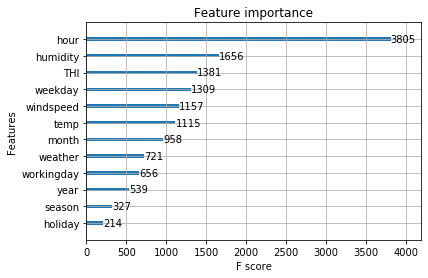

In [245]:
from xgboost import plot_importance
plot_importance(model)
plt.show()